In [1]:
# plotting
import matplotlib.pyplot as plt

# image processing
import cv2

# opening files and paths
import os

# import utility functions
from shapely_conversion import convert
from shapely_utilities import *

# import spiral generation
import spiral as S
import fermat_spiral as FS

# optimization module
from optimization import optimization

import time

%reload_ext autoreload
%autoreload 2

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None, endpoints=False):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
            if path and endpoints:
                pyplot.scatter(path[0][0], path[0][1], c='green')
                pyplot.scatter(path[-1][0], path[-1][1], c='red')
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [3]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def generate_polygons(image, optimize=False, simplify=1):
    
    opt_reg=1
    opt_smh=10
    opt_spacing=1
    
    samples = 1
            
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
    
    formatted_polygons = []
    
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        if optimize:
            
            optimize_time = time.time()
            s = list(sample(polygon.exterior,samples).coords)
            
            if len(s) > 5:
                ext = optimization(s, opt_reg, opt_smh, opt_spacing, False)

                ints = []

                for interior in polygon.interiors:
                    i = list(sample(interior,samples).coords)
            
                    if len(i) > 5:
                        ints.append(optimization(i, opt_reg, opt_smh, opt_spacing, False))

                polygon = Polygon(ext, holes=ints)

                print("\tOptimize:", time.time()-optimize_time)
                
                # simplify the shape to remove excess points
                polygon = polygon.simplify(simplify)

        else:
            polygon = polygon.simplify(simplify)
        
        formatted_polygons.append(polygon)
        
    return formatted_polygons

In [96]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 10

# filename of image to process
filename = 'files/pokemons.png'

# image should be in binary format
image = cv2.imread(filename,0)

print(not image is None)

polygons = generate_polygons(image, True, simplify=1)

True
	Optimize: 1.4519646167755127
	Optimize: 1.4684078693389893
	Optimize: 2.9921159744262695
	Optimize: 1.8163604736328125
	Optimize: 3.0726070404052734
	Optimize: 3.452937602996826
	Optimize: 5.137397050857544
	Optimize: 1.8628761768341064
	Optimize: 3.3125815391540527
	Optimize: 1.2961790561676025
	Optimize: 1.3489506244659424
	Optimize: 1.552870512008667
	Optimize: 2.0020620822906494
	Optimize: 2.380772590637207
CPU times: user 32.6 s, sys: 15.5 s, total: 48.1 s
Wall time: 33.3 s


In [133]:
%%time
results = FS.execute(polygons, distance, boundaries=0)
# results = FS.execute(polygons, distance, connected=True, boundaries=1)

NONE
1  - FS 0.6953237658959054
1  - FS 1.0000100591229328
1  - FS 1.0070400929984296
1  - FS 1.0040698434875628
2  - FS 1.0046428665188774
1  - FS 0.7764188594662534
2  - FS 0.7764188594662534
1  - FS 1.0060506047499933
1  - FS 1.0060214547833326
2  - FS 1.005938199159315
1  - FS 0.9740370890937838
CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.07 s


<IPython.core.display.Javascript object>


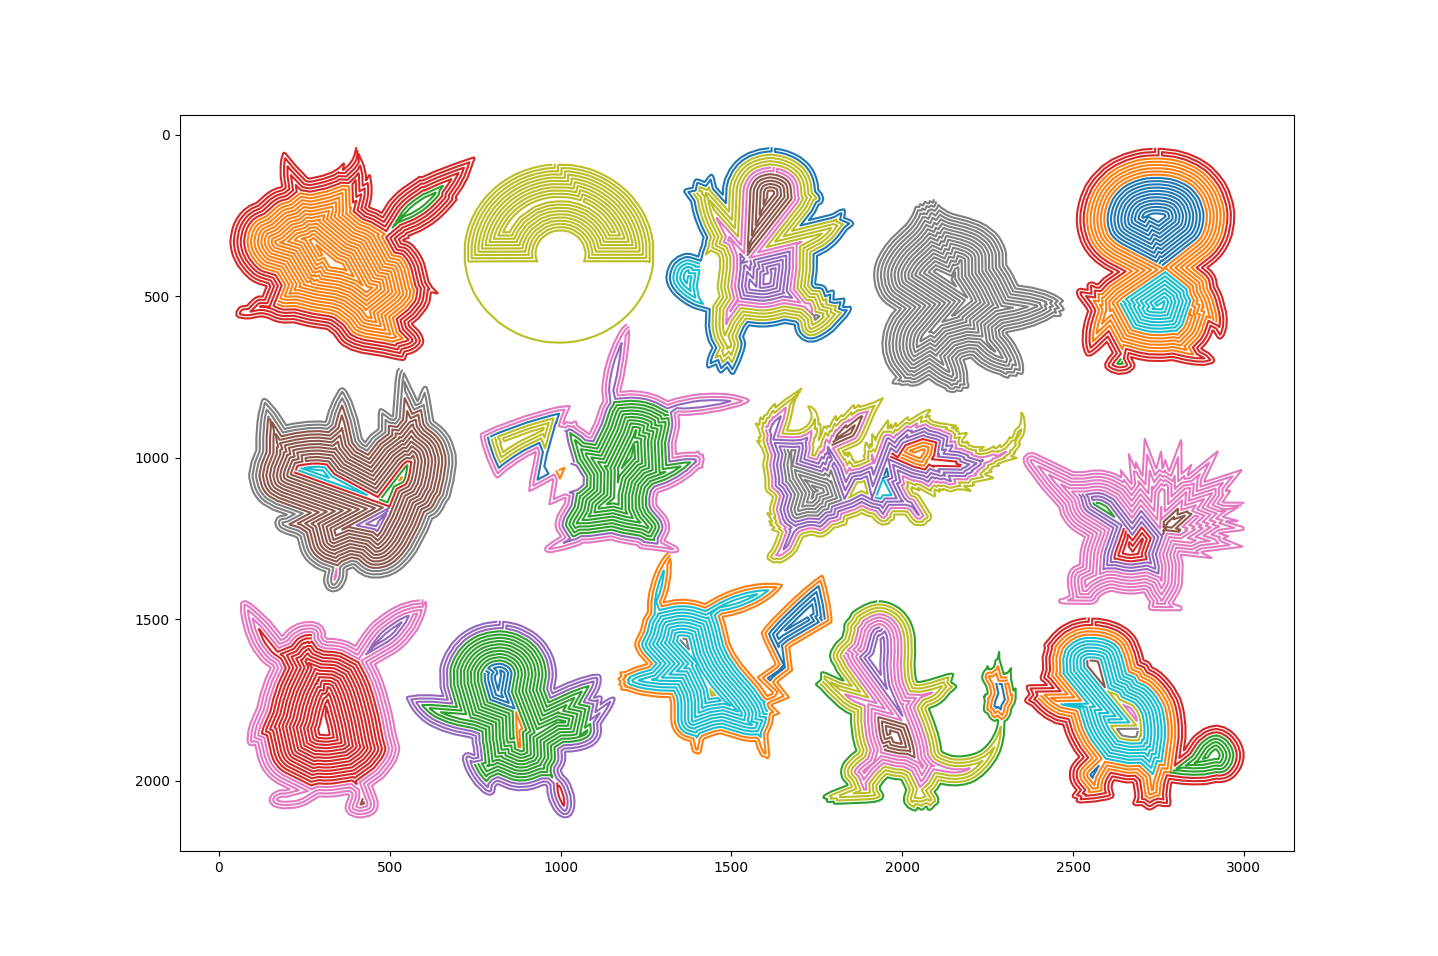

In [134]:
plot_recursive_path(results)
plt.gca().invert_yaxis()

In [112]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [92]:
plot_path(polygons[1].exterior.coords)

In [91]:
plot_path(polygons[1].interiors[0].coords)

In [89]:
dt = distance_transform(polygons[1], -distance)

<IPython.core.display.Javascript object>


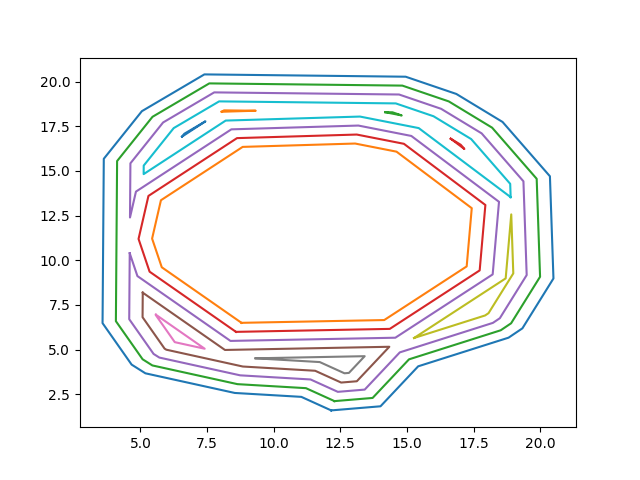

In [93]:
def recursion(temp):
    
    
    for t in temp:
        
        if type(t) is list:
            recursion(t)
        else:
            plot_path(t.exterior.coords)
            for i in t.interiors:
                plot_path(i.coords)
recursion(dt)

In [6]:
'''
Generate a virtual boundary  ~ this is a list of polygons that are buffered by the distance
 - this creates "boundaries" that can be used to constraint the outer shape of the path
'''
virtual_boundary_list = [polygon.buffer(distance) for polygon in polygons]


# get all of the boundary points of polygon as a single list
# this adds exterior and interior points into the same list
def get_all_boundary_points(polygon):
    
    points = list(polygon.exterior.coords)
    
    for interior in polygon.interiors:
        points.extend(list(interior.coords))
        
    return points

In [12]:
for polygon in virtual_boundary_list:
    plot_path(polygon.exterior.coords, color='orange')

In [123]:
from metrics import Metrics

measurer = Metrics(segments=True, commands=True, curvature=False, underfill=True)

1
1 1.0002249400533483


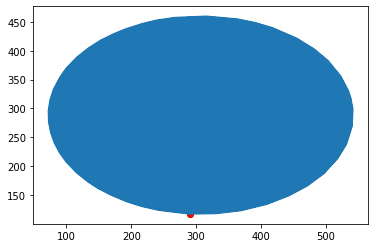

2
1 1.0003140133139008


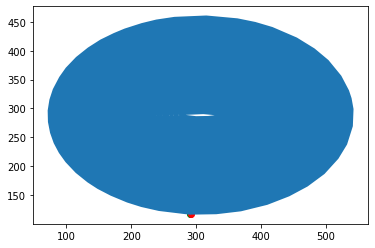

3
1 1.0005630324255468


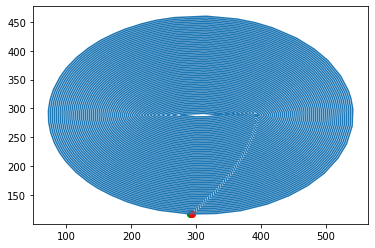

4
1 1.0008827823916755


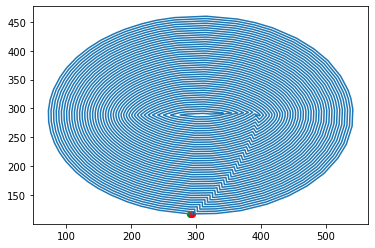

5
1 1.000678572701133


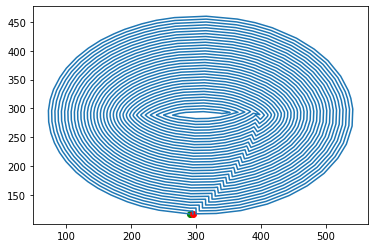

6
1 1.0006291858194514


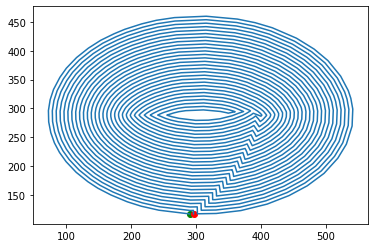

7
1 1.0005249794642084


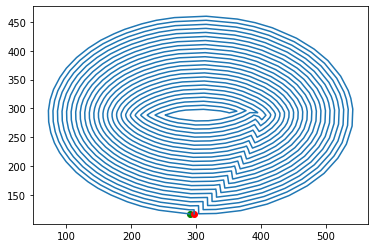

8
1 1.0009039215212008


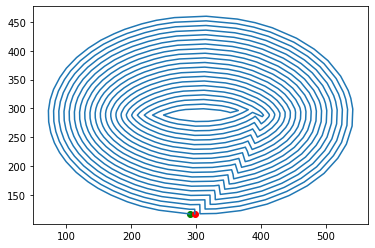

9
1 1.0014238868003214


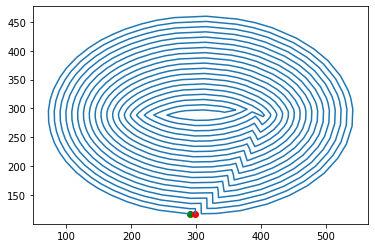

In [135]:
'''
Test different fills
'''

%matplotlib inline

metrics = []

for i in range(1,10):
    print(i)
    results = FS.execute(polygons, i, connected=True)
    plot_recursive_path(results)
    pyplot.show()
    metrics.append(measurer.measure(results, "CFS", i, polygons))

In [138]:
'''
Converting results to dataframe
'''
import pandas as pd

data = pd.DataFrame(metrics)

data

Method  Distance  Segments  Commands  Curvature  Underfill  Overfill
0    CFS         1         1      7341        NaN   0.000325       NaN
1    CFS         2         1      3667        NaN   0.001364       NaN
2    CFS         3         1      2448        NaN   0.001214       NaN
3    CFS         4         1      1841        NaN   0.001150       NaN
4    CFS         5         1      1467        NaN   0.003350       NaN
5    CFS         6         1      1220        NaN   0.006513       NaN
6    CFS         7         1      1045        NaN   0.007484       NaN
7    CFS         8         1       913        NaN   0.008248       NaN
8    CFS         9         1       815        NaN   0.005128       NaN

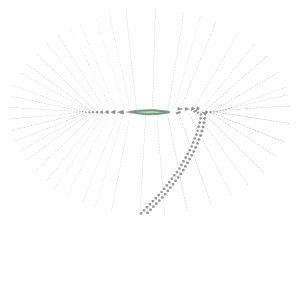

In [132]:
'''
Display the underfill areas (sanity check)
'''

from shapely.geometry import MultiPolygon

path_areas = [LineString(path).buffer(distance/2+0.001) for path in results]
MultiPolygon(polygons).difference(MultiPolygon(path_areas))

In [43]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            
            if not b:
                print("EMPTY!")
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [120]:
from gcode import GcodeWriter

In [125]:
len(results[-1])

0

In [127]:
gc = GcodeWriter(filename='wolf_temp.gcode', scale = 0.1)

db_list = gc.convert_supervase(results[0:-1], height=0.3)

In [128]:
import numpy as np
arr = np.array(db_list)

x = arr[:,0]
y = arr[:,1]
z = arr[:,2]

<IPython.core.display.Javascript object>


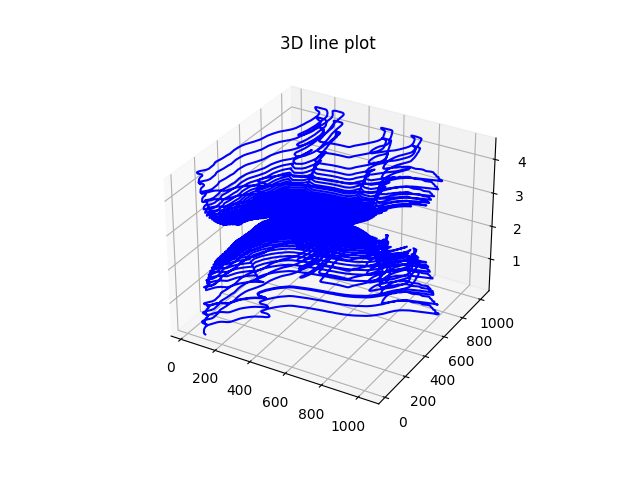

In [129]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(x, y,z, 'blue')
ax.set_title('3D line plot')
plt.show()




<IPython.core.display.Javascript object>


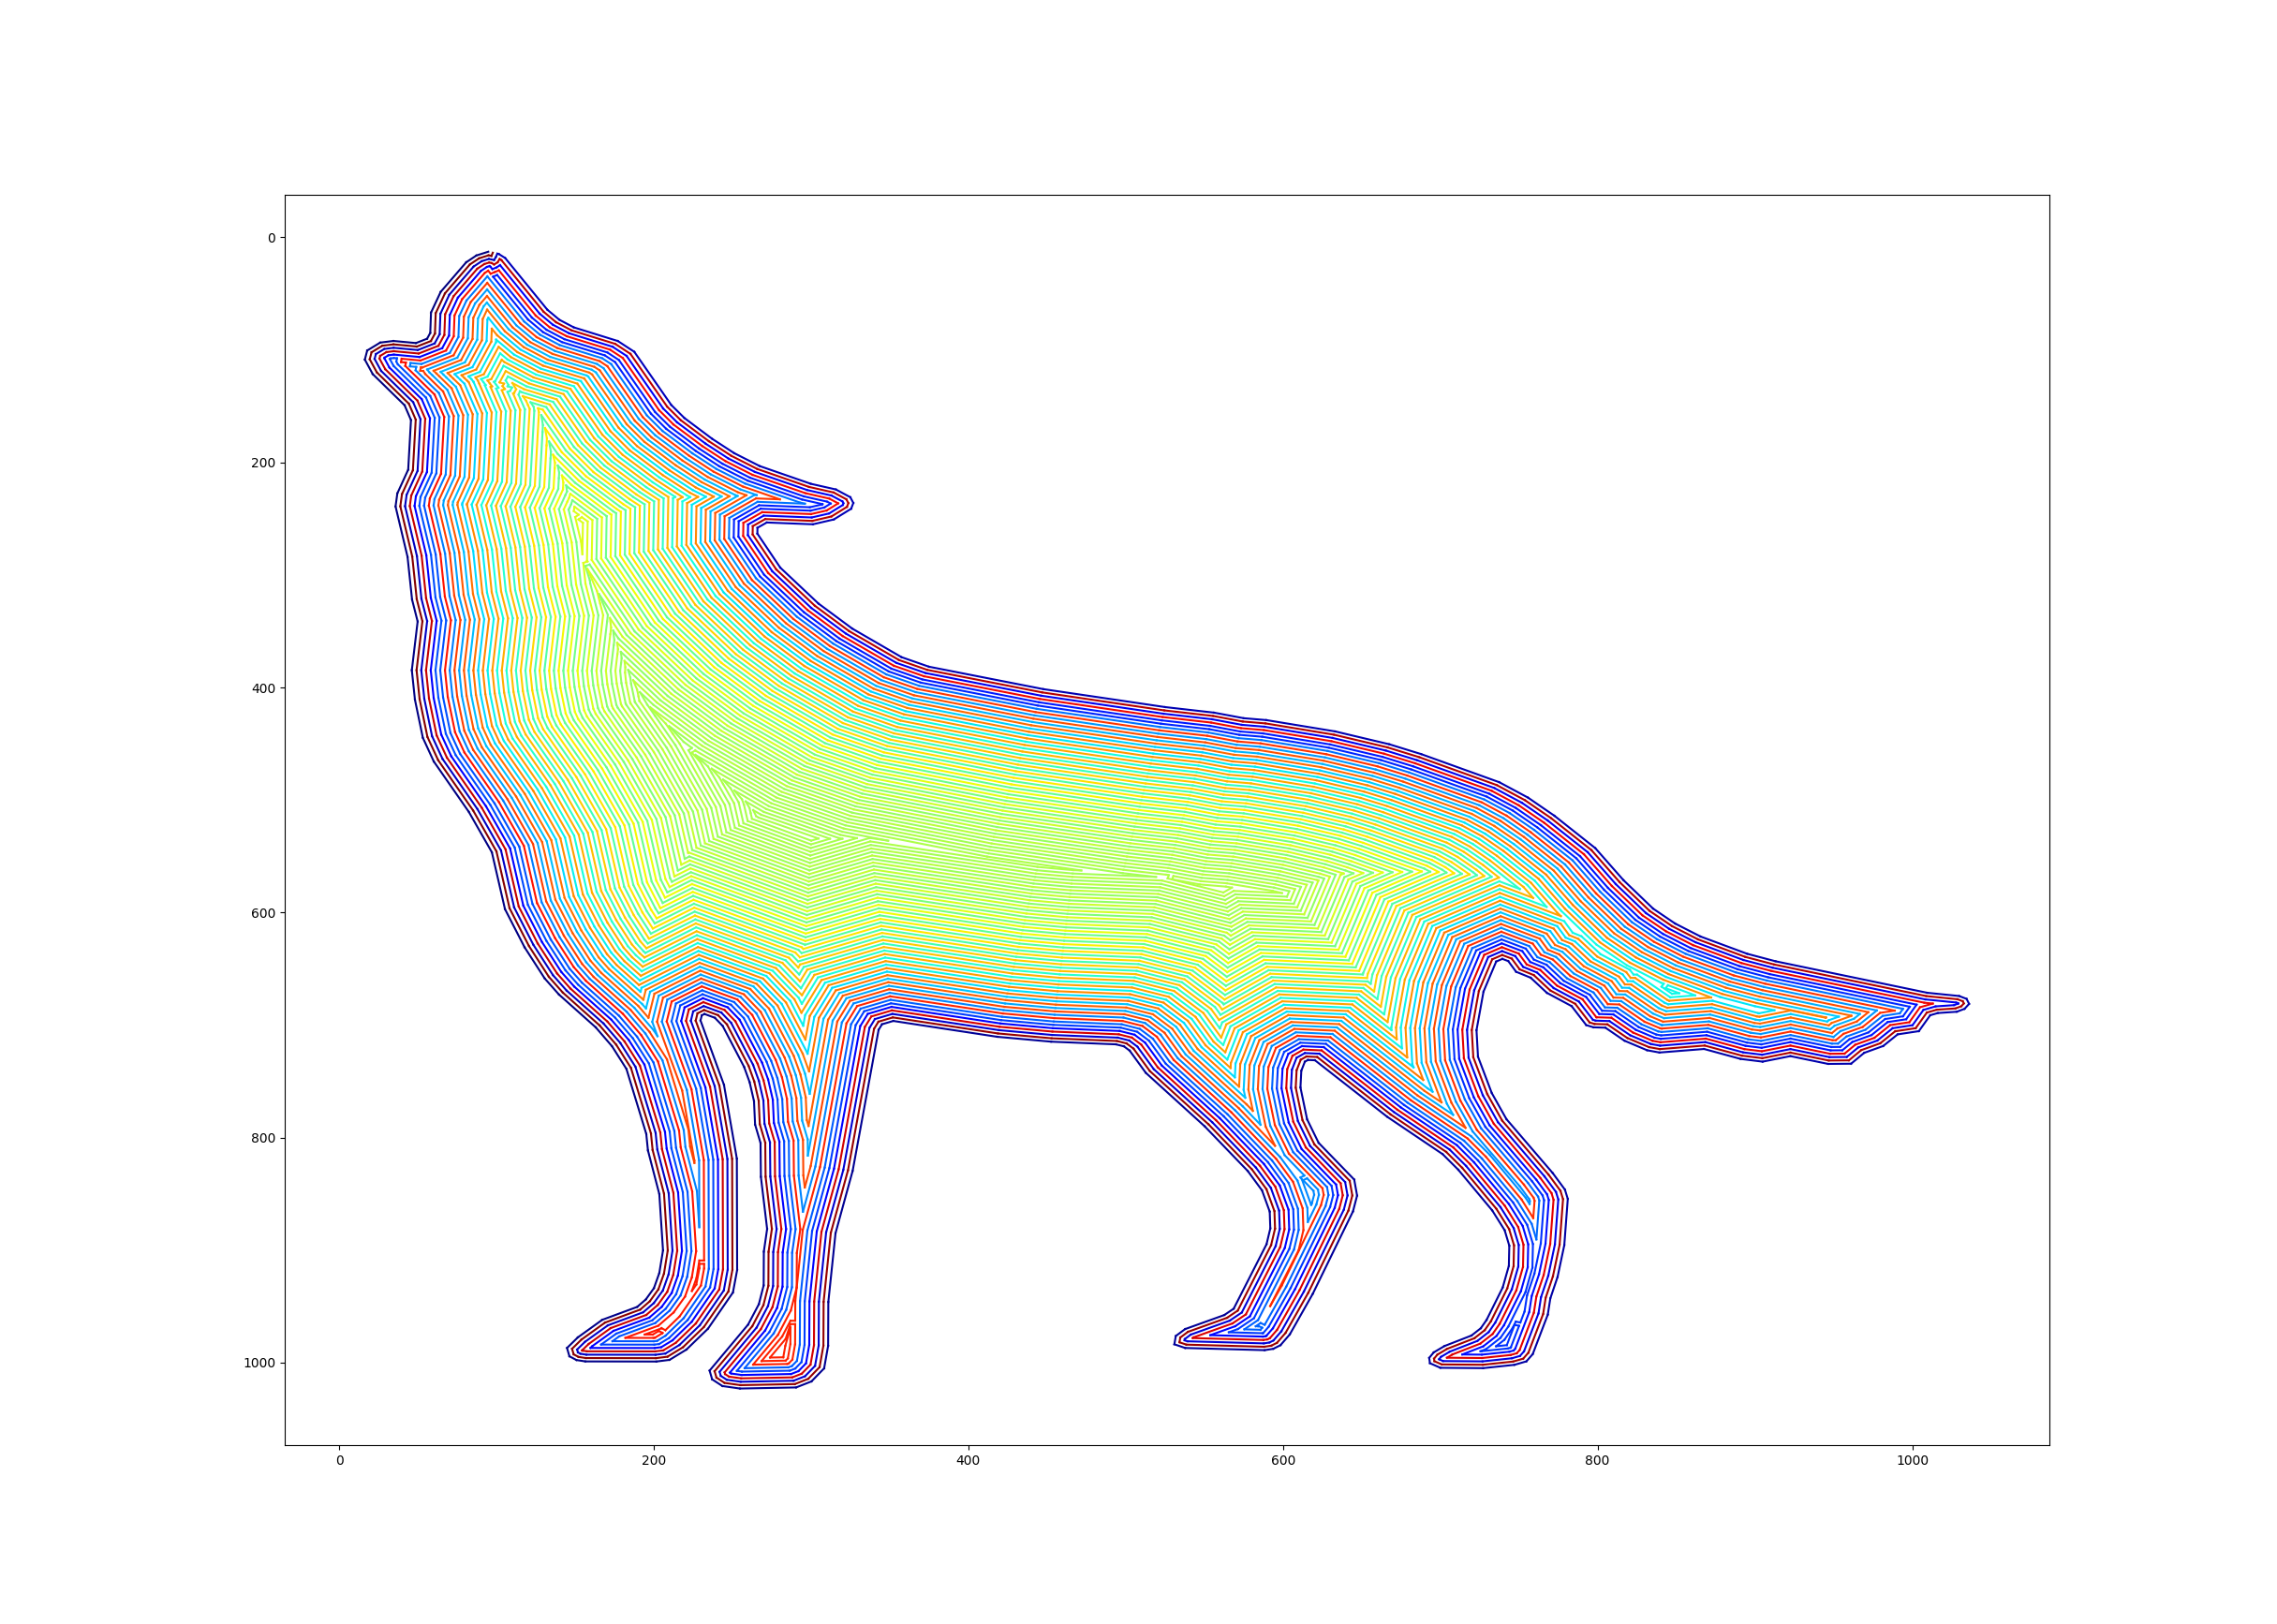

In [130]:
%matplotlib notebook

NPOINTS = len(x)
MAP = 'jet'

# Choose a color map, loop through the colors, and assign them to the color 
# cycle. You need NPOINTS-1 colors, because you'll plot that many lines 
# between pairs. In other words, your line is not cyclic, so there's 
# no line from end to beginning
cm = plt.get_cmap(MAP)
color = [cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)]
for i in range(NPOINTS-1):
    plt.plot(x[i:i+2],y[i:i+2], c=color[i])
plt.gca().invert_yaxis()

In [ ]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path